In [1]:
import numpy as np
import pandas as pd
import pcreode
import math
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings( 'ignore')

In [14]:
def get_data( fact):
    # get curved trajectory 
    a = 25
    b = 20
    x0 = 12
    y0 = 0
    bot = np.arange(-math.pi, -math.pi/4.0, (math.pi - math.pi/4.0)/(500*fact)) + np.random.uniform( -0.006, 0.006, 500*fact)
    x_ep = x0 + a*np.cos( bot) + np.random.uniform( -2.0, 2.0, len(bot))
    y_ep = y0 + b*np.sin( bot) + np.random.uniform( -2.0, 2.0, len(bot))
    
    # get center linear trajectory
    n_end_points = 750
    x_l = np.random.uniform(-30.0, 15.0, n_end_points)
    y_l = np.random.uniform( -1.8,  1.8, n_end_points)
    
    # bot linear branch
    x_bot = np.random.uniform( 15, 40, n_end_points)
    y_bot = (-4/5.0)*x_bot + 12 + np.random.uniform( -2.0, 2.0, len(x_bot))

    # top linear branch
    x_top = np.random.uniform( 15, 40, n_end_points)
    y_top = (4/5.0)*x_top + -12 + np.random.uniform( -2.0, 2.0, len(x_top))
    
    # mid linear branch
    x_mid = np.random.uniform( 0, 12, n_end_points)
    y_mid = (7/5.0)*x_mid + 0 + np.random.uniform( -2.2, 2.2, len(x_mid))
    
    x = np.append( x_ep, [x_l, x_bot, x_top, x_mid])
    y = np.append( y_ep, [y_l, y_bot, y_top, y_mid])
    
    return( np.transpose( np.vstack( [x,y])))

In [15]:
data = get_data( 2)

((-40, 50), (-40, 50))

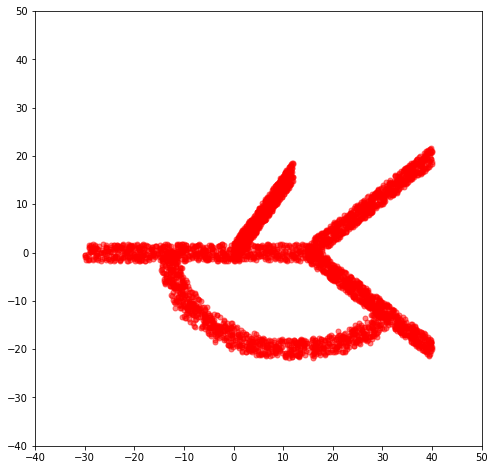

In [16]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = 'r'
ax1.scatter( data[:,0], data[:,1], alpha=0.5, s=25, c=cc)
ax1.set_xlim(-40,50), ax1.set_ylim(-40,50)

best guess starting radius = 0.638994010296


0.6389940102956033

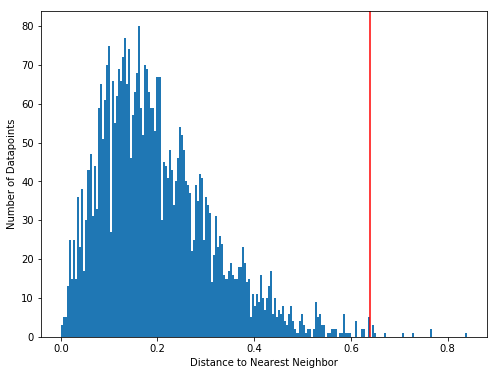

In [17]:
dens = pcreode.Density( data)
dens.nearest_neighbor_hist()

calculating densities for datapoints: 0 -> 3999
****Always check density overlay for radius fit****


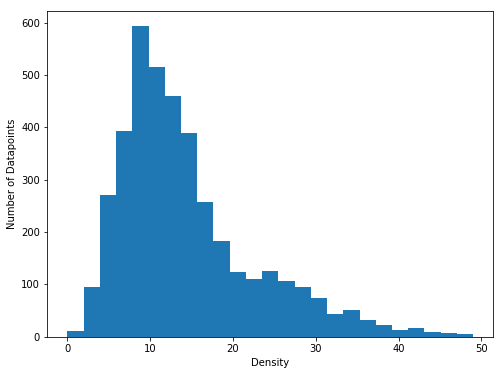

In [18]:
density = dens.get_density( radius=0.80)
dens.density_hist( n_bins=25)

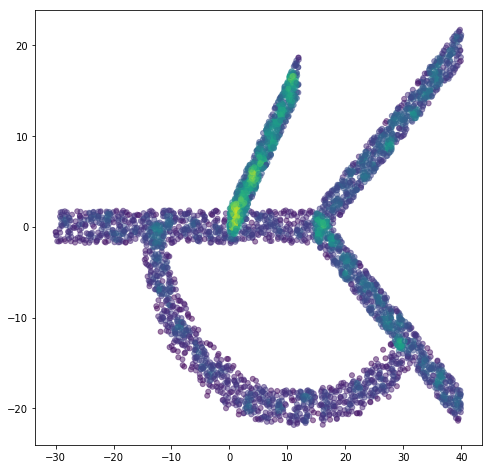

In [19]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = density
ax1.scatter( data[:,0], data[:,1], alpha=0.5, s=25, c=cc)

In [20]:
noise  = 0.0
target = 10.0

In [21]:
downed, downed_ind = pcreode.Down_Sample( data, density, noise, target)

Number of data points in downsample = 2171


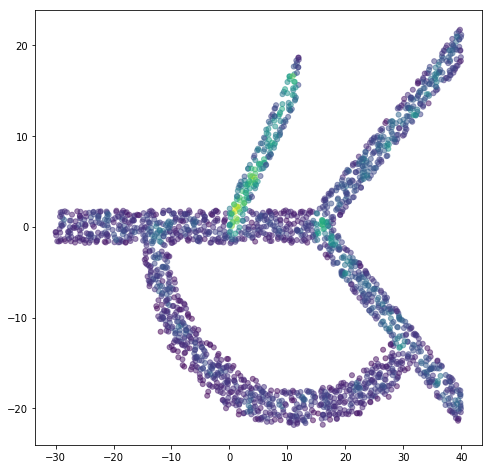

In [22]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = density[downed_ind]
ax1.scatter( downed[:,0], downed[:,1], alpha=0.5, s=25, c=cc)

In [23]:
data = get_data( 2)
endstates_ind, down_ind, clust_ids, std_cls = pcreode.find_endstates( data, density, noise, target, potential_clusters=10, cls_thresh=-1.0)

Number of data points in downsample = 2183
Constructing density kNN
finding endstates
Number of endstates found -> 8


(-30, 30)

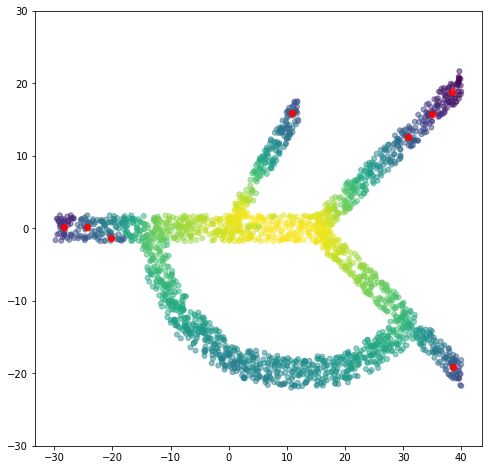

In [24]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = std_cls
ax1.scatter( data[down_ind,0], data[down_ind,1], alpha=0.5, s=25, c=cc)
ax1.scatter( data[endstates_ind,0], data[endstates_ind,1], alpha=0.9, s=40, c='r')
ax1.set_ylim(-30,30)

In [25]:
file_path = "../test/"

In [26]:
out_graph, out_ids = pcreode.pCreode( data=data, density=density, noise=noise, target=target, file_path=file_path, num_runs=1, cls_thresh=-1.0)

Performing 1 independent runs, may take some time
Number of data points in downsample = 2143
Constructing density kNN
finding endstates
Number of endstates found -> 8
hierarchical placing
consensus aligning
saving files for run_num 1


(-30, 30)

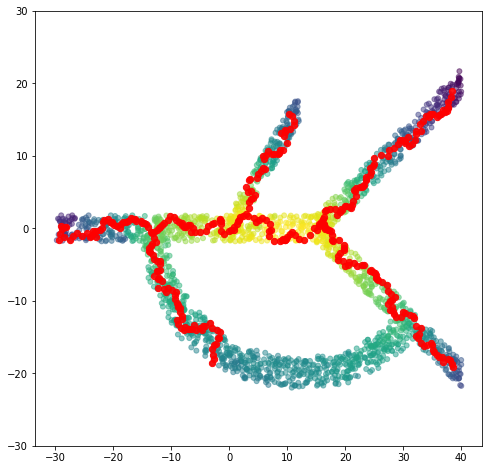

In [27]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = std_cls
ax1.scatter( data[down_ind,0], data[down_ind,1], alpha=0.5, s=25, c=cc)
ax1.scatter( data[out_ids,0], data[out_ids,1], alpha=0.9, s=40, c='r')
ax1.set_ylim(-30,30)

(-30, 30)

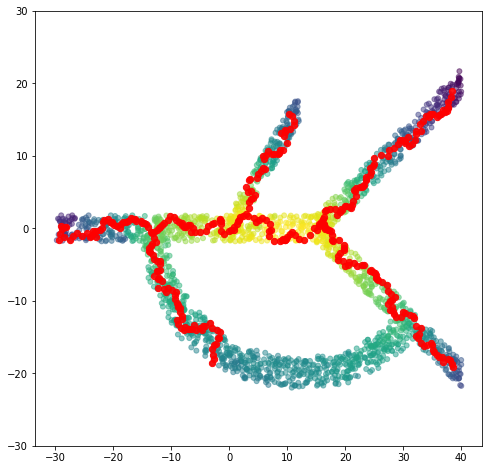

In [28]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = std_cls
ax1.scatter( data[down_ind,0], data[down_ind,1], alpha=0.5, s=25, c=cc)
ax1.scatter( data[out_ids,0], data[out_ids,1], alpha=0.9, s=40, c='r')
ax1.set_ylim(-30,30)

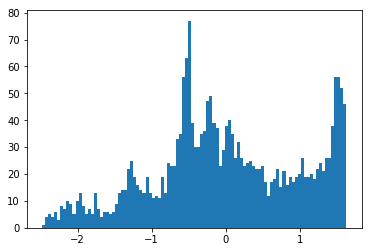

In [29]:
_ = plt.hist( std_cls, bins=100)

In [30]:
import igraph as _igraph
import matplotlib.pyplot as _plt
import random
from igraph import *
from sklearn.metrics import pairwise_distances
from sklearn.cluster import KMeans as _KMeans
from sklearn import preprocessing
from sklearn import metrics
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
import os as _os

In [232]:
def pCreode( data, density, noise, target, file_path, num_runs=100, potential_clusters=10, cls_thresh=0.0, start_id=0, mute=False):
    ''' 
    Function for running full pCreode algorithm, with the addition of principle component extremes found to be under the closeness threshold added as endstates
    :param data:    numpy ndarray of data set
    :param density: numpy array of calculated densities for each datapoint
    :param noise:   value for noise threshold, densities below value will be removed during downsampling
    :param target:  value for target density
    :param file_path: path to directory where output files will be stored
    :param num_runs:  number of independent runs to perform, default is 100 
    :param potential_clusters: value for upper range of number of clusters to search for, default value is 10
    :param cls_thresh: value for closeness threshold use to separate potential endstates from transitional cell types default value is 0.0
    :param start_id: integer at which to start labeling output graphs, allows for addition of graphs to previously ran lot
    :param  mute: boolean operator to suppress print statements
    :return: will save creode files in given directory
    '''
    if not ( isinstance( data, np.ndarray)):
        raise TypeError( 'data variable must be numpy ndarray')
    if not ( isinstance( density, np.ndarray)):
        raise TypeError( 'data variable must be numpy array')
    if not ( _os.path.exists( file_path)):
        raise TypeError( 'please supply a valid directory')
        
    # Save sys.stdout to return print output if muted 
    old_stdout = sys.stdout
    # Mute print statements if True
    if( mute==True):
        sys.stdout = open( os.devnull, 'w')
        
    print( "Performing {0} independent runs, may take some time".format( num_runs))
  
    for run_itr in range( num_runs):
        
        # get downsampled dataset
        down, down_ind = pcreode.Down_Sample( data, density, noise, target)

        # array for orginal density (prior to downsampling) of downsampled data points
        down_density = density[down_ind]
        n_down       = len( down)

        # get distance matrix for down sampled dataset
        Dist = np.array( pairwise_distances( down, down, n_jobs=1))

        # set upper and lower thresholds for number of neighbors to connect in density 
        # based nearest neighbor graph (d-kNN) (current fixed values are 2 and 10)
        upper_nn = 25
        lower_nn = 2

        # assign number of neighbors to connect to, to each datapoint 
        sorted_nn = np.linspace( lower_nn, upper_nn, n_down, dtype=int)
        nn = np.zeros( n_down, dtype=int)
        nn[np.argsort( down_density)] = sorted_nn

        # create adjacency matrix to hold neighbor connections for d-kNN
        knn_adj = np.zeros( ( n_down, n_down), dtype=int)
        for zz in range( n_down):
            knn_adj[zz,np.argsort( Dist[zz,:])[1:nn[zz]]] = 1
        # to make symetric add adj with transpose
        knn_adj = np.add( knn_adj, knn_adj.T)
        
        # make sure there is only one component by constructing a MST
        Dist_csr = csr_matrix( np.triu(Dist))
        Tcsr     = minimum_spanning_tree( Dist_csr)
        mst_adj  = pd.DataFrame( Tcsr.todense()).values
        mst_adj  = np.add( mst_adj, mst_adj.T)
        
        # add the two adjacency matrices
        adj = np.add( knn_adj, mst_adj)
        
        # make sure overlaping neighbors arnt double counted
        adj[adj>0] = 1.0

        # normalize the orginal densities of the downsampled data points
        norm = preprocessing.MinMaxScaler()
        dens_norm = np.ravel( norm.fit_transform( down_density.reshape( -1, 1).astype( np.float)))

        # weight edges of d-kNN by inverse of orginal densities
        den_adj = np.zeros( ( n_down, n_down), dtype=float)
        print( "Constructing density kNN")
        # get coordinates of connections from adjacency matrix
        adj_coords = np.nonzero( np.triu( adj))
        for hh, uu in zip( adj_coords[0], adj_coords[1]):
            # take the minimum density of nodes connected by the edge
            # add 0.1 so that no connection is lost (not equal to zero)
            den_adj[hh,uu] = 1.1 - ( min( [dens_norm[hh], dens_norm[uu]]))
        # make symetric 
        den_adj  = np.add( den_adj, den_adj.T)
        # final edge weights are product of density weights and distance matrix
        dist_weighted_adj = np.multiply( Dist, adj)
        dens_weighted_adj = np.multiply( Dist, den_adj)
        # create undirected igraph instance using weighted matrix
        d_knn = _igraph.Graph.Weighted_Adjacency( dist_weighted_adj.tolist(), loops=False, mode=ADJ_UNDIRECTED)

        print( "finding endstates")
        # get closeness of graph and standardize to aid in endstate identification
        cls     = np.array( d_knn.closeness( weights="weight"))
        scaler  = preprocessing.StandardScaler()
        std_cls = scaler.fit_transform( cls.reshape(-1,1)).ravel()

        # using closeness as threshold (default value = 0.0) get potential endstates
        low_cls = down[std_cls<=cls_thresh]
        # array to hold silhouette score for each cluster try
        sil_score = [0]*potential_clusters

        # prefrom K means clustering and score each attempt
        for ss in range( potential_clusters):
            kmeans_model  = _KMeans( n_clusters=ss+2, random_state=10).fit( low_cls)
            label         = kmeans_model.labels_
            sil_score[ss] = metrics.silhouette_score( low_cls, labels=label, metric='l2')

        # find most likely number of clusters from scores above and double to allow for rare cell types
        num_clusters = ( np.argmax( sil_score) + 2)# * 2
        clust_model = _KMeans( n_clusters=num_clusters, random_state=10).fit( low_cls)
        label      = clust_model.labels_
        print( "Number of endstates found -> {0}".format( num_clusters))

        endstates = clust_model.cluster_centers_
        endstates_ind = np.zeros( (num_clusters, 1), dtype=int)
        for ii in range( num_clusters):
            endstates_ind[ii] = pcreode.find_closest_ind( endstates[ii], down)
        
        endstates_ind = endstates_ind.ravel()
        endstates = data[endstates_ind,:]
        num_clusters = len( endstates_ind)
        cen_ind = endstates_ind
        '''
        # Endstate data points were picked from full data set, so need to be appended to down and down_ind
        # Create array to hold where end_states are located within the downsampled dataset
        cen_ind = np.zeros( num_clusters, dtype=int)
        ind = n_down
        for es in range( num_clusters):
            # first need to check if they are already in the graph, if not:
            if( ~np.in1d( endstates_ind[es], down_ind)):
                down     = np.vstack( ( down, endstates[es]))
                down_ind = np.append( down_ind, endstates_ind[es])
                cen_ind[es] = ind
                ind = ind + 1
            # if data point is already in down
            else:
                cen_ind[es] = np.argwhere( endstates_ind[es]==down_ind).ravel()[0]
                continue
        '''
        # re-initialize using density and distance weighted edges         
        dens_knn = _igraph.Graph.Weighted_Adjacency( dens_weighted_adj.tolist(), loops=False, mode=ADJ_UNDIRECTED)
        '''
        # add endstate data points to the already constructed dens_knn graph, connecting to 2 closest neighbors
        # future update will so that number of edges is based on density of data point
        knn_num = 5
        # add nodes to graph that will represent endstates
        dens_knn.add_vertices( num_clusters)
        d_knn.add_vertices( num_clusters)
        # get distance matrix to be used for finding closeset neighbors in graph
        end_dist = np.array( pairwise_distances( endstates, down[:-num_clusters], n_jobs=1))
        for kk in range( num_clusters):
            edg_wts = np.sort( end_dist[kk,:])[1:knn_num+1]
            edg_ids = np.argsort( end_dist[kk,:])[1:knn_num+1]
            for jj in range( knn_num):
                # no need to connect if connection is already present
                if( edg_wts[jj]<2.0e-06):
                    continue
                # if not present add edge with distance/density weight
                else:
                    dens_knn.add_edge( cen_ind[kk], edg_ids[jj], weight=edg_wts[jj]*(1-dens_norm[edg_ids[jj]]))
                    d_knn.add_edge( cen_ind[kk], edg_ids[jj], weight=edg_wts[jj])
        '''            
        print( "hierarchical placing")
        # perform hierarchical placement of endstates (find shortest paths connecting them within d_knn)
        hi_pl, hi_pl_ind = pcreode.hierarchical_placement( dens_knn, cen_ind)
        print( "consensus aligning")
        # perform consensus alignment of hierarchical placement data points
        aligned_ind = pcreode.consensus_alignment( down, hi_pl_ind.copy(), data, density, noise)
        # add orginal endstates back into aligned list of indices 
        al_es_ind = np.append( cen_ind, np.unique( aligned_ind[~np.in1d( aligned_ind, cen_ind)]))
        # perform hierarchical placement of of newly aligned data points
        al_hi_pl, al_hi_pl_ind = pcreode.hierarchical_placement( dens_knn, al_es_ind)
        # rerun hierarchical placement on the aligned placement graph to eliminate superfluous edges
        # by re-feeding it the orginal endstate indices
        creode_graph, creode_ind = pcreode.hierarchical_placement( al_hi_pl, range( len( cen_ind)))
        creode_graph.simplify( combine_edges="mean")
        print( "saving files for run_num {0}".format( run_itr + 1))
        np.savetxt( file_path + "ind_{0}.csv".format( start_id), down_ind[al_hi_pl_ind[creode_ind]], delimiter=',')
        creode_graph.save( file_path + "adj_{0}.txt".format( start_id), format="adjacency" )
        
        start_id = start_id + 1
        
    # return to normal treatment of print statements
    sys.stdout = old_stdout
        
    return( creode_graph, down_ind[al_hi_pl_ind[creode_ind]], down_ind, d_knn, al_hi_pl_ind[creode_ind], cen_ind, dens_weighted_adj, hi_pl, hi_pl_ind, dens_knn)
    

In [233]:
out_graph, out_ids, down_ind, d_knn, run_ind, cen_ind, dens_adj, hi_pl, hi_pl_ind, dens_knn = pCreode( data=data, density=density, noise=noise, target=target, file_path=file_path, num_runs=1, cls_thresh=-1.0)
down = data[down_ind]

Performing 1 independent runs, may take some time
Number of data points in downsample = 2167
Constructing density kNN
finding endstates
Number of endstates found -> 4
hierarchical placing
consensus aligning
saving files for run_num 1


In [234]:
# find all branch points
degree   = np.transpose( out_graph.degree())
brch_ids = np.argwhere( degree>2).flatten()

In [235]:
# get neighbors of branching nodes
def get_neighbors( nodes): 
    brnb_ids = nodes
    for ii in nodes:
        brnb_ids = np.append( brnb_ids, out_graph.neighbors(ii))
    return( brnb_ids)

nn = get_neighbors( brch_ids)
for ii in range( 10):
    nn = np.append( nn, np.unique( get_neighbors( nn))) 
nn_ids = np.unique( nn)
nn_ids

array([ 39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61, 105, 106, 107,
       108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
       121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
       134, 135, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176])

(-30, 30)

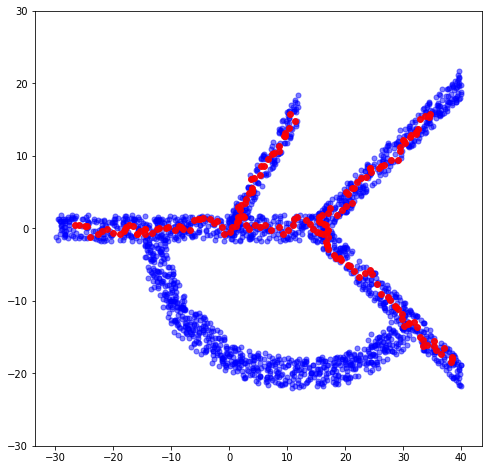

In [236]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = "blue"
ax1.scatter( data[down_ind,0], data[down_ind,1], alpha=0.5, s=25, c=cc)
ax1.scatter( data[out_ids,0], data[out_ids,1], alpha=0.9, s=35, c='r')
ax1.set_ylim(-30,30)

(-30, 30)

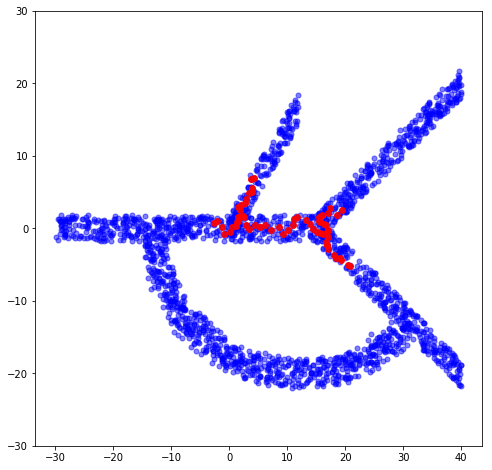

In [237]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = "blue"
ax1.scatter( down[:,0], down[:,1], alpha=0.5, s=25, c=cc)
ax1.scatter( data[out_ids[nn_ids],0], data[out_ids[nn_ids],1], alpha=0.9, s=35, c='r')
ax1.set_ylim(-30,30)

In [238]:
# get graph distance matrix to bin data to nodes
g_dist = pcreode.get_graph_distance( np.arange( d_knn.vcount()), run_ind, d_knn)

In [239]:
# bin downsampled data points to each node
bin_id = np.argsort( g_dist, axis=1)[:,1]
len(bin_id), nn_ids

(2167, array([ 39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61, 105, 106, 107,
        108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120,
        121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133,
        134, 135, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176]))

In [240]:
brch_bins = np.zeros_like( bin_id)
no_branch_ids = np.array( [], dtype=int)
for ii in nn_ids:
    brch_bins[np.argwhere( bin_id==ii).ravel()] = 1
no_branch_ids = np.argwhere(brch_bins==0).ravel()
nono_branch_ids = np.argwhere(brch_bins==1).ravel() 

no_branch_ids

array([   0,    1,    2, ..., 2164, 2165, 2166])

(-30, 30)

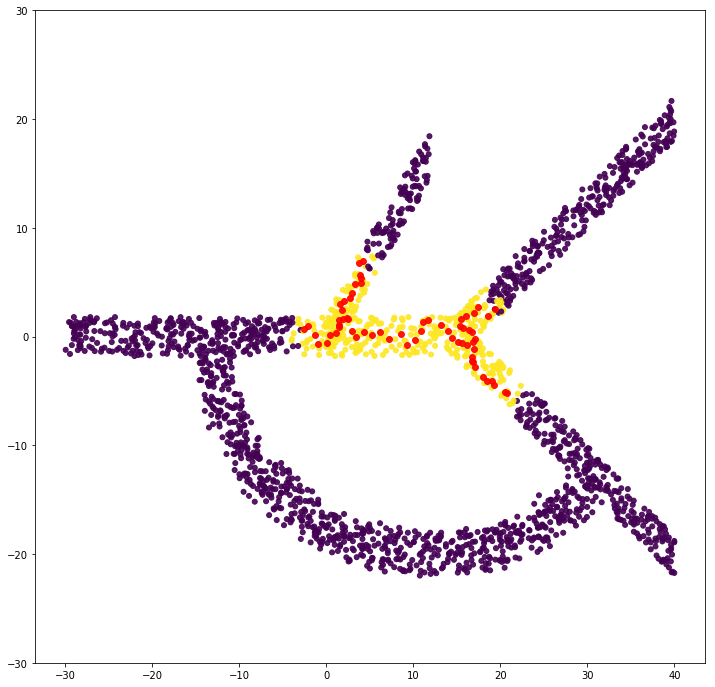

In [241]:
fig = plt.figure( figsize=(12,12))
ax1 = fig.add_subplot(111)
cc = brch_bins
ax1.scatter( data[down_ind,0], data[down_ind,1], alpha=0.9, s=25, c=cc)
ax1.scatter( data[out_ids[nn_ids],0], data[out_ids[nn_ids],1], alpha=0.9, s=35, c='r')
ax1.set_ylim(-30,30)

In [242]:
no_branch_data = data[down_ind[no_branch_ids],:]

In [243]:
# create new knn graphs with branching data points removed
# set upper and lower thresholds for number of neighbors to connect in density 
# based nearest neighbor graph (d-kNN) (current fixed values are 2 and 10)
upper_nn = 25
lower_nn = 2

# need to recalculate the density of no_branch_data
br_dens = pcreode.Density( no_branch_data)
br_density = br_dens.get_density( radius=0.80)

calculating densities for datapoints: 0 -> 1699
****Always check density overlay for radius fit****


(-30, 30)

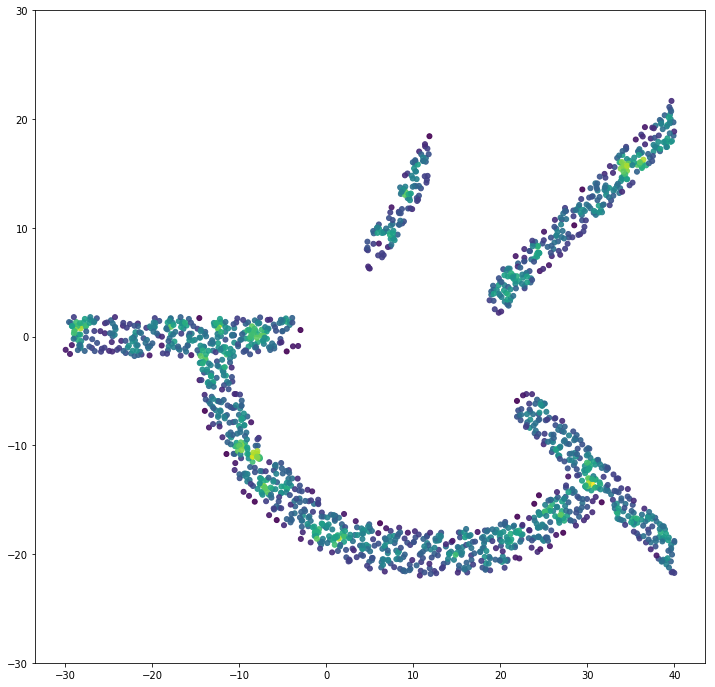

In [244]:
fig = plt.figure( figsize=(12,12))
ax1 = fig.add_subplot(111)
cc = br_density
ax1.scatter( no_branch_data[:,0], no_branch_data[:,1], alpha=0.9, s=25, c=cc)
ax1.set_ylim(-30,30)

In [245]:
# assign number of neighbors to connect to, to each datapoint 
br_sorted_nn = np.linspace( lower_nn, upper_nn, len( no_branch_data), dtype=int)
br_nn = np.zeros_like( br_density)
br_nn[np.argsort( br_density)] = br_sorted_nn

# create adjacency matrix to hold neighbor connections for d-kNN
br_knn_adj = np.zeros( ( len( br_density), len( br_density)), dtype=int)
br_dist = pairwise_distances( no_branch_data, no_branch_data)
for zz in range( len( br_density)):
    br_knn_adj[zz,np.argsort( br_dist[zz,:])[1:br_nn[zz]]] = 1
# to make symetric add adj with transpose
br_knn_adj = np.add( br_knn_adj, br_knn_adj.T)
br_knn_adj[br_knn_adj>0] = 1.0
br_dist_weighted_adj = np.multiply( br_dist, br_knn_adj)
brd_knn = _igraph.Graph.Weighted_Adjacency( br_dist_weighted_adj.tolist(), loops=False, mode=ADJ_UNDIRECTED)

In [246]:
comps = np.array( brd_knn.components())

In [247]:
cocl = np.zeros_like( br_density)
for ii in range( len( comps)):
    cocl[comps[ii]] = ii * 10

In [248]:
br_ends = np.zeros_like( cen_ind)
for ii, cen_itr in enumerate( cen_ind):
    br_ends[ii] = pcreode.find_closest_ind( point=data[down_ind[cen_itr]], data=no_branch_data)
br_ends

array([1519, 1017, 1117, 1657])

(-30, 30)

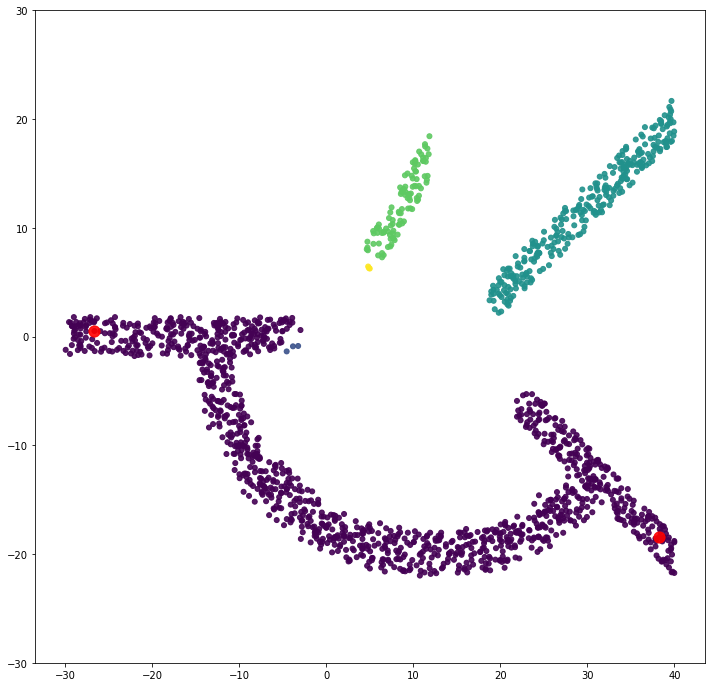

In [249]:
fig = plt.figure( figsize=(12,12))
ax1 = fig.add_subplot(111)
cc = cocl
ax1.scatter( no_branch_data[:,0],       no_branch_data[:,1],       alpha=0.9, s=25,  c=cc)
ax1.scatter( no_branch_data[br_ends[1:3],0], no_branch_data[br_ends[1:3],1], alpha=0.9, s=125, c='r')
ax1.set_ylim(-30,30)

In [250]:
comp_adj = dens_adj.copy()
# remove all branching data point edges
comp_adj[nono_branch_ids,:] = 0
comp_adj[:,nono_branch_ids] = 0

#comp_adj = np.delete( comp_adj, nono_branch_ids, axis=0)
#comp_adj = np.delete( comp_adj, nono_branch_ids, axis=1)

for cc in range( len( comps)):
    if( sum(xx in comps[cc] for xx in br_ends)<=1):
        comp_adj[no_branch_ids[comps[cc]],:] = 0
        comp_adj[:,no_branch_ids[comps[cc]]] = 0
    else:
        print "yes"
        
len( np.nonzero( comp_adj)[0])

yes


17444

In [251]:
comp_knn = _igraph.Graph.Weighted_Adjacency( comp_adj.tolist(), loops=False, mode=ADJ_UNDIRECTED)

In [252]:
#print comp_knn.components()
comps = np.array( comp_knn.components())
cocl = np.zeros_like( down_ind)

cocl[comps[0]] = 1 

In [253]:
cen_ind

array([1883, 1219, 1368, 2090])

In [254]:
run_ind

array([1883, 1219, 1368, 2090,  971, 1076, 1164,  984, 1190,  834,  871,
        787, 1137, 1205, 1200, 1052, 1094, 1121,  912,  919,  990, 1011,
          5, 1082, 1002, 1207, 1107, 1117,  734,  805, 1021, 1230, 1247,
        922,  884, 1168, 1161,  996,  786,  733,  758,  980, 1188, 1985,
       2128, 2111, 2137,  930,  838, 2019, 2145, 2124, 2105, 2047, 1980,
       2011, 2144, 1984, 1996, 2138, 2083, 2056, 2033, 2130, 2030, 2044,
       2067, 2131, 2082, 2024, 2012, 2021, 1995, 2020, 2092, 1629, 1724,
       1743, 1934, 1612, 1652, 1621, 1772, 1858, 1636, 1618, 1742, 1796,
       1643, 1959, 1623, 1680, 1875, 1920, 1711, 1650, 1787, 1964, 1786,
       1798, 1720, 1894, 1763, 1860, 1740, 1653, 1922, 1806, 1891, 1936,
       1966, 1825, 1762, 1298, 1674, 1464, 1574, 1470, 1341, 1857, 1153,
       1078,  809,  888, 1096,  737,  814, 1025,  740,  914, 1032, 1038,
        935,  836,  802, 2100, 1440, 1511, 1436, 1385, 1524, 1308, 1498,
       1490, 1494, 1439, 1516, 1597, 1545, 1306, 13

In [255]:
comp_ends = hi_pl_ind[np.isin( hi_pl_ind, comps[0])]
comp_ends

array([1219, 1368, 1109,  791, 1064,  789,  727,  938,  873,  970, 1165,
       1216, 1221, 1026,  729,    4,  957,  926, 1060, 1099,  766,  947,
        939, 1440, 1511, 1436, 1253, 1337, 1595, 1439, 1516, 1597, 1306,
       1600, 1538, 1500, 1543, 1467, 1390, 1485, 1605, 1502])

In [256]:
alt_rte, alt_ind = pcreode.hierarchical_placement( comp_knn, comp_ends)

(-30, 30)

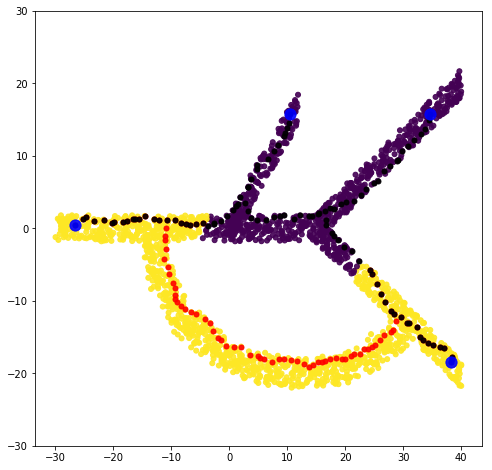

In [257]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = cocl
ax1.scatter( data[down_ind,0], data[down_ind,1], alpha=0.9, s=25, c=cc)
ax1.scatter( data[down_ind[alt_ind],0], data[down_ind[alt_ind],1], alpha=0.9, s=25, c='r')
ax1.scatter( data[down_ind[hi_pl_ind],0], data[down_ind[hi_pl_ind],1], alpha=0.9, s=25, c='black')
ax1.scatter( data[down_ind[cen_ind],0], data[down_ind[cen_ind],1], alpha=0.9, s=125, c='blue')
ax1.set_ylim(-30,30)

In [258]:
# combine alternate route graph and pcreode graph node indices, downsampled indices
all_inds = np.unique( np.append( hi_pl_ind, alt_ind))

In [259]:
# run consensus alignment on combined alternate route and pcreode graph
all_aligned_ind = pcreode.consensus_alignment( data[down_ind], all_inds.copy(), data, density, noise)
all_aligned_ind

array([  15,   36,   49,   57,   60,   72,   91,  103,  128,  130,  147,
        171,  178,  180,  197,  219,  241,  242,  250,  283,  287,  318,
        340,  359,  366,  382,  402,  404,  410,  417,  424,  439,  484,
        485,  497,  523,  528,  538,  543,  545,  556,  560,  590,  596,
        604,  605,  621,  645,  656,  659,  677,  709,  714,  715,  744,
        759,  766,  775,  794,  818,  876,  879,  887,  923,  925,  926,
        934,  938,  942,  961,  964,  990,  995,  999, 1020, 1021, 1066,
       1068, 1106, 1123, 1126, 1131, 1143, 1161, 1163, 1165, 1195, 1223,
       1227, 1228, 1249, 1256, 1257, 1258, 1288, 1298, 1315, 1343, 1353,
       1362, 1373, 1390, 1406, 1434, 1447, 1480, 1497, 1498, 1499, 1515,
       1538, 1547, 1550, 1552, 1566, 1579, 1581, 1605, 1622, 1672, 1673,
       1676, 1686, 1688, 1749, 1782, 1789, 1791, 1816, 1822, 1861, 1909,
       1930, 1932, 1934, 1935, 1952, 1959, 1965, 1966, 1969, 1973, 1988,
       2020, 2026, 2033, 2042, 2044, 2047, 2071, 20

In [260]:
# add orginal endstates back into aligned list of indices 
all_es_ind = np.append( cen_ind, np.unique( all_aligned_ind[~np.in1d( all_aligned_ind, cen_ind)]))
cen_ind, all_es_ind

(array([1883, 1219, 1368, 2090]),
 array([1883, 1219, 1368, 2090,   15,   36,   49,   57,   60,   72,   91,
         103,  128,  130,  147,  171,  178,  180,  197,  219,  241,  242,
         250,  283,  287,  318,  340,  359,  366,  382,  402,  404,  410,
         417,  424,  439,  484,  485,  497,  523,  528,  538,  543,  545,
         556,  560,  590,  596,  604,  605,  621,  645,  656,  659,  677,
         709,  714,  715,  744,  759,  766,  775,  794,  818,  876,  879,
         887,  923,  925,  926,  934,  938,  942,  961,  964,  990,  995,
         999, 1020, 1021, 1066, 1068, 1106, 1123, 1126, 1131, 1143, 1161,
        1163, 1165, 1195, 1223, 1227, 1228, 1249, 1256, 1257, 1258, 1288,
        1298, 1315, 1343, 1353, 1362, 1373, 1390, 1406, 1434, 1447, 1480,
        1497, 1498, 1499, 1515, 1538, 1547, 1550, 1552, 1566, 1579, 1581,
        1605, 1622, 1672, 1673, 1676, 1686, 1688, 1749, 1782, 1789, 1791,
        1816, 1822, 1861, 1909, 1930, 1932, 1934, 1935, 1952, 1959, 1965,
    

In [261]:
# perform hierarchical placement of newly aligned data points
all_hi_pl, all_hi_pl_ind = pcreode.hierarchical_placement( dens_knn, all_es_ind)

In [ ]:
# now the unwanted endstates need to be removed
# these should sum to 1, so we iter through and remove until 
# we only have our original endstates 

In [272]:
np.array( all_hi_pl.get_adjacency().data)

(370, 370)

In [266]:
alter_nodes = down_ind[all_hi_pl_ind]

(-30, 30)

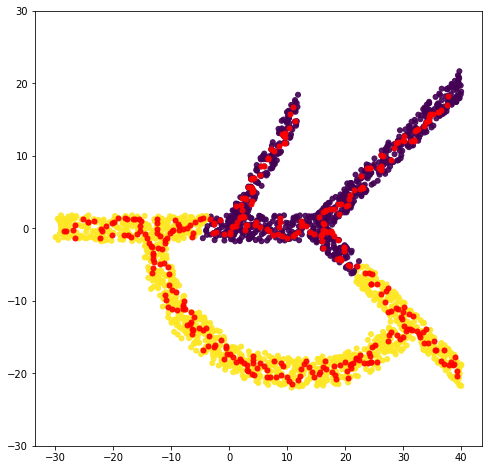

In [267]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = cocl
ax1.scatter( data[down_ind,0], data[down_ind,1], alpha=0.9, s=25, c=cc)
ax1.scatter( data[alter_nodes,0], data[alter_nodes,1], alpha=0.9, s=25, c='r')
ax1.set_ylim(-30,30)

In [ ]:
# rerun hierarchical placement on the aligned placement graph to eliminate superfluous edges
# by re-feeding it the orginal endstate indices
#creode_graph, creode_ind = pcreode.hierarchical_placement( all_hi_pl, range( len( cen_ind)))
#creode_graph.simplify( combine_edges="mean")

In [41]:
bin_id = np.argsort( down_node_dist, axis=1)[:,0]
#pd.value_counts( bin_id)

NameError: name 'down_node_dist' is not defined

In [ ]:
fig = plt.figure( figsize=(8,8))
ax1 = fig.add_subplot(111)
cc = bin_id
ax1.scatter( data[down_ind,0], data[down_ind,1], alpha=0.5, s=25, c=cc)
ax1.scatter( data[out_ids,0], data[out_ids,1], alpha=0.9, s=35, c='r')
ax1.set_ylim(-30,30)